In [1]:
import cv2

vidcap = cv2.imread('big_buck_bunny_720p_5mb.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

In [17]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

## Bag of Visual Words(BoVW)

### Load train and test images into dictionaries.

In [48]:
# takes all images and convert them to grayscale. 
# return a dictionary that holds all images category by category. 
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat,0)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                category.append(img)
        images[filename] = category
    return images

images = load_images_from_folder('../Images/train_small/')  # take all images category by category 
test = load_images_from_folder("../Images/test/") # take test images

### Extract features with SIFT

In [49]:
# Creates descriptors using sift 
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds the descriptors but this is seperated class by class
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images)
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1]

### Send the visual dictionary to the k-means clustering algorithm

In [70]:
# A k-means clustering algorithm that takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words

# Takes the central points which is visual words    
visual_words = kmeans(100, descriptor_list)

### Create histograms for both test and train images.

In [71]:
# Find the index of the closest central point to the each sift descriptor. 
# Takes 2 parameters the first one is a sift descriptor and the second one is the array of central points in k means
# Returns the index of the closest central point.  
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

# Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class 
# And the second parameter is an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class. 
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words)

### Predict classes of the test images

In [72]:
# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Call the knn function    
results_bowl = knn(bovw_train, bovw_test) 

In [73]:
results_bowl

[66, 42, {'Books': [22, 24], 'Boxes': [19, 21], 'Cups': [1, 21]}]

In [74]:
# Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + ": %" + str(acc))
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl)

Average accuracy: %63.63636363636363

Class based accuracies: 

Books: %91.66666666666666
Boxes: %90.47619047619048
Cups: %4.761904761904762


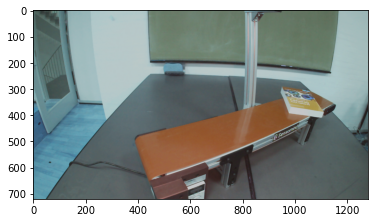

In [22]:
img = cv2.imread('../Images/test/Books/1585434296_930432081_Left.png')
#plt.imshow(img[200:700, 400:1200])
plt.imshow(img)

In [25]:
def getRectangleCenter(p1,p2):
	x = int(p1[0] + (p2[0] - p1[0])/2)
	y = int(p1[1] + (p2[1] - p1[1])/2)
	return (x,y)

# %% SETTINGS and VARIABLES DEFINITION
h, w = cv2.imread('../Images/test/Books/1585434296_930432081_Left.png').shape[:2] # size of the images (pixels)

# define region of the belt
belt_contour = np.array([[[387,476]],[[464,696]],[[1217,359]],[[1131,260]]])
belt_x0 = 400 # x start of the conveyor (pixels)
belt_x1 = 1240 # x end of the conveyor (pixels)

# mask to remove hands
mask_belt_x = np.zeros((h,w),dtype='uint8')
mask_belt_x[:,belt_x0:belt_x1] = 255

# define kernels
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# initialize background subtractor
fgbg = cv2.createBackgroundSubtractorKNN(history=600,dist2Threshold=800, detectShadows=False)

# initialize roi
point1_start = (1030,240)
point2_start = (1270,440)
point1 = point1_start
point2 = point2_start
center_rectangle = getRectangleCenter(point1, point2)
center_rectangle_prev = (0,0)


frame = cv2.imread('../Images/test/Books/1585434296_930432081_Left.png')
mask_fg = fgbg.apply(frame)
mask_blue = getBlueMask(frame)


In [47]:
import numpy as np
import cv2

cap = cv2.VideoCapture('../Stereo conveyor without occlusions.mp4')

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorMOG2()
counter = 0
while(1):
    ret, frame = cap.read()

    mask = fgbg.apply(frame)
    # Morphological opening and closing to improve mask
    mask_morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    mask_morph = cv2.morphologyEx(mask_morph, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    # Generate output
    output = cv2.bitwise_and(frame, frame, None, mask_morph)
    cv2.imshow('output', output)
    #cv2.imwrite('../Images/segmented images/frame' + str(counter) + '.png',output)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    counter += 1

cap.release()
cv2.destroyAllWindows()

In [85]:
import natsort
natsort.natsorted(os.listdir(folder),reverse=False)

['leftimage0.png',
 'leftimage1.png',
 'leftimage2.png',
 'leftimage3.png',
 'leftimage4.png',
 'leftimage5.png',
 'leftimage6.png',
 'leftimage7.png',
 'leftimage8.png',
 'leftimage9.png',
 'leftimage10.png',
 'leftimage11.png',
 'leftimage12.png',
 'leftimage13.png',
 'leftimage14.png',
 'leftimage15.png',
 'leftimage16.png',
 'leftimage17.png',
 'leftimage18.png',
 'leftimage19.png',
 'leftimage20.png',
 'leftimage21.png',
 'leftimage22.png',
 'leftimage23.png',
 'leftimage24.png',
 'leftimage25.png',
 'leftimage26.png',
 'leftimage27.png',
 'leftimage28.png',
 'leftimage29.png',
 'leftimage30.png',
 'leftimage31.png',
 'leftimage32.png',
 'leftimage33.png',
 'leftimage34.png',
 'leftimage35.png',
 'leftimage36.png',
 'leftimage37.png',
 'leftimage38.png',
 'leftimage39.png',
 'leftimage40.png',
 'leftimage41.png',
 'leftimage42.png',
 'leftimage43.png',
 'leftimage44.png',
 'leftimage45.png',
 'leftimage46.png',
 'leftimage47.png',
 'leftimage48.png',
 'leftimage49.png',
 'leftimag

In [82]:
import re

folder = '../Calibration/videos_rectified/not_occluded/left/'
print(os.listdir(folder).sort(key=lambda f: int(re.sub('\D', '', f))))

None


In [99]:
import numpy as np
import cv2

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorKNN()
counter = 0

folder = '../Calibration/videos_rectified/not_occluded/left/'
counter = 0

for filename in natsort.natsorted(os.listdir(folder)):
    frame = cv2.imread(os.path.join(folder,filename))
    
    if frame is not None:
        mask = fgbg.apply(frame)
        # Morphological opening and closing to improve mask
        mask_morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)))
        mask_morph = cv2.morphologyEx(mask_morph, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
        # Generate output
        output = cv2.bitwise_and(frame, frame, None, mask_morph)
        #cv2.imshow('output', output)
        cv2.imwrite('../Images/segmented_images/frame' + str(counter) + '.png',output)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
        counter += 1

cap.release()
cv2.destroyAllWindows()

## Classification with CNN weights

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

C:\Users\bekar\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


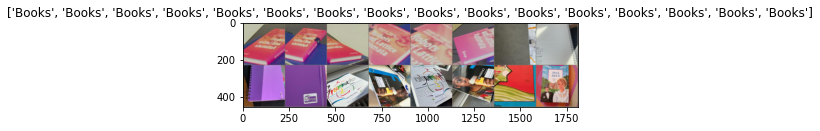

In [103]:
test = 'test'
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test: transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../Images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', test]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=False, num_workers=4)
              for x in ['train', test]}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', test]}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

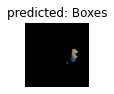

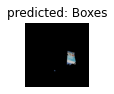

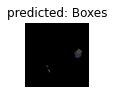

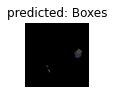

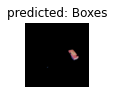

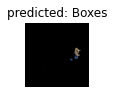

In [10]:
# constant for classes
classes = ('Book', 'Box', 'Cup')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model.fc = nn.Linear(num_ftrs, 3)
model = model

model.load_state_dict(torch.load("../../pfas_ft.pt", map_location=torch.device('cpu')))
model.eval()

In [108]:
all_preds = []
class_names = ['Book', 'Box', 'Cup']

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[test]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for pred in preds:
            all_preds.append(class_names[pred])

In [112]:
import cv2
import os
# font
font = cv2.FONT_HERSHEY_SIMPLEX
  
# org
org = (50, 50)
fontScale = 1
thickness = 2
   
folder = '../Calibration/videos_rectified/not_occluded/left/'
folder_results = '../Images/results/'
counter = 0
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
        if all_preds[counter] == 'Cup':
            color = (255, 0, 0)
            image = cv2.putText(img, all_preds[counter], org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
        if all_preds[counter] == 'Box':
            color = (0, 255, 0)
            image = cv2.putText(img, all_preds[counter], org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
        else:
            color = (0, 0, 255)
            image = cv2.putText(img, all_preds[counter], org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
        cv2.imwrite(os.path.join(folder_results,filename), image)
        counter += 1